In [ ]:
import pandas as pd
import numpy as np
# df1=pd.read_csv("/content/kidnapping.csv")
# df2=pd.read_csv("/content/murder.csv")
# df3=pd.read_csv("/content/sexhar.csv")



In [ ]:
df=pd.read_csv("/content/final.csv")

In [ ]:
df.head()

,text,label
0,"At about 8:00 pm on 10.09.1996, the\r\ndecease...",murder
1,"between 26th and 27th November, 2000 when all ...",murder
2,"The case of the prosecution in brief is that, ...",murder
3,I submit that my wife burnt to death this\r\ne...,murder
4,They entered the house and saw\r\nParamjit Sin...,murder


In [ ]:
df.label.describe()

count                152
unique                 3
top       sexual offense
freq                  51
Name: label, dtype: object

In [ ]:
#df['word_length'] = df['cleanData'].apply(lambda x:len(x.split()))
df.dtypes

text     object
label    object
dtype: object

In [ ]:
df['target']=df.label.map({"murder":0,"kidnapping":1,"sexual offense":2})

In [ ]:
df.columns=['text','label','target']

In [ ]:
df.target.astype(int)

0      0
1      0
2      0
3      0
4      0
      ..
147    1
148    1
149    1
150    1
151    1
Name: target, Length: 152, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.text,df.target, test_size = 0.2, stratify = df.target,random_state = 42)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
len(tokenizer.word_index)

3447

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=171,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 171, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(121, 171) (31, 171)


In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

In [ ]:
glove_gensim['cat'].shape[0]

300

In [ ]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(300)

In [ ]:
print(gensim_weight_matrix.shape)
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

(10000, 300)


In [ ]:
EMBEDDING_DIM = 300 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(300,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(400,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(200,return_sequences=False)))
model_gensim.add(Dense(3, activation = 'softmax'))
model_gensim.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
model_gensim.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 300)          3000000   
                                                                 
 dropout (Dropout)           (None, 171, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 171, 600)         1444800   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 171, 600)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 171, 800)         3206400   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 171, 800)          0

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc


roc= EarlyStopping(monitor='auc_roc', patience=300, verbose=1, mode='max')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 60, batch_size = 100, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc,roc]  )

Epoch 1/60
2/2 [==============================] - ETA: 0s - loss: 1.0912 - accuracy: 0.3802
Epoch 1: val_accuracy improved from -inf to 0.35484, saving model to ./model_gensim.h5


2/2 [==============================] - 9s 2s/step - loss: 1.0912 - accuracy: 0.3802 - val_loss: 1.8167 - val_accuracy: 0.3548
Epoch 2/60
2/2 [==============================] - ETA: 0s - loss: 1.6522 - accuracy: 0.4050
Epoch 2: val_accuracy improved from 0.35484 to 0.51613, saving model to ./model_gensim.h5


2/2 [==============================] - 1s 646ms/step - loss: 1.6522 - accuracy: 0.4050 - val_loss: 1.0567 - val_accuracy: 0.5161
Epoch 3/60
2/2 [==============================] - ETA: 0s - loss: 0.9796 - accuracy: 0.5289
Epoch 3: val_accuracy did not improve from 0.51613


2/2 [==============================] - 1s 217ms/step - loss: 0.9796 - accuracy: 0.5289 - val_loss: 1.0578 - val_accuracy: 0.4194
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 0.8982 - accuracy: 0.5620
Epoch 4: val_accuracy improved from 0.51613 to 0.67742, saving model to ./model_gensim.h5


2/2 [==============================] - 1s 547ms/step - loss: 0.8982 - accuracy: 0.5620 - val_loss: 0.9420 - val_accuracy: 0.6774
Epoch 5/60
2/2 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.6694
Epoch 5: val_accuracy did not improve from 0.67742


2/2 [==============================] - 1s 220ms/step - loss: 0.7663 - accuracy: 0.6694 - val_loss: 0.9885 - val_accuracy: 0.6452
Epoch 6/60
2/2 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.6942
Epoch 6: val_accuracy did not improve from 0.67742


2/2 [==============================] - 1s 223ms/step - loss: 0.6817 - accuracy: 0.6942 - val_loss: 0.8136 - val_accuracy: 0.6774
Epoch 7/60
2/2 [==============================] - ETA: 0s - loss: 0.5615 - accuracy: 0.7934
Epoch 7: val_accuracy did not improve from 0.67742


2/2 [==============================] - 1s 218ms/step - loss: 0.5615 - accuracy: 0.7934 - val_loss: 0.8202 - val_accuracy: 0.6452
Epoch 8/60
2/2 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7934
Epoch 8: val_accuracy improved from 0.67742 to 0.74194, saving model to ./model_gensim.h5


2/2 [==============================] - 1s 540ms/step - loss: 0.4889 - accuracy: 0.7934 - val_loss: 0.7595 - val_accuracy: 0.7419
Epoch 9/60
2/2 [==============================] - ETA: 0s - loss: 0.4095 - accuracy: 0.8512
Epoch 9: val_accuracy improved from 0.74194 to 0.80645, saving model to ./model_gensim.h5


2/2 [==============================] - 1s 553ms/step - loss: 0.4095 - accuracy: 0.8512 - val_loss: 0.7407 - val_accuracy: 0.8065
Epoch 10/60
2/2 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.9008
Epoch 10: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 218ms/step - loss: 0.3633 - accuracy: 0.9008 - val_loss: 0.7562 - val_accuracy: 0.7742
Epoch 11/60
2/2 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.9091
Epoch 11: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 218ms/step - loss: 0.2808 - accuracy: 0.9091 - val_loss: 0.9050 - val_accuracy: 0.7097
Epoch 12/60
2/2 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.9256
Epoch 12: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 219ms/step - loss: 0.2339 - accuracy: 0.9256 - val_loss: 0.9328 - val_accuracy: 0.6452
Epoch 13/60
2/2 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9174
Epoch 13: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 216ms/step - loss: 0.2176 - accuracy: 0.9174 - val_loss: 0.7277 - val_accuracy: 0.7742
Epoch 14/60
2/2 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9669
Epoch 14: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 221ms/step - loss: 0.1204 - accuracy: 0.9669 - val_loss: 0.9691 - val_accuracy: 0.7097
Epoch 15/60
2/2 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9256
Epoch 15: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 226ms/step - loss: 0.1731 - accuracy: 0.9256 - val_loss: 1.1341 - val_accuracy: 0.6774
Epoch 16/60
2/2 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9669
Epoch 16: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 218ms/step - loss: 0.0938 - accuracy: 0.9669 - val_loss: 1.2577 - val_accuracy: 0.6774
Epoch 17/60
2/2 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9587
Epoch 17: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 225ms/step - loss: 0.1001 - accuracy: 0.9587 - val_loss: 1.1235 - val_accuracy: 0.7419
Epoch 18/60
2/2 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9835
Epoch 18: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 226ms/step - loss: 0.0439 - accuracy: 0.9835 - val_loss: 1.1522 - val_accuracy: 0.7419
Epoch 19/60
2/2 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9669
Epoch 19: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 222ms/step - loss: 0.0726 - accuracy: 0.9669 - val_loss: 0.8641 - val_accuracy: 0.7742
Epoch 20/60
2/2 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9752
Epoch 20: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 225ms/step - loss: 0.0735 - accuracy: 0.9752 - val_loss: 0.9106 - val_accuracy: 0.7419
Epoch 21/60
2/2 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9835
Epoch 21: val_accuracy did not improve from 0.80645


2/2 [==============================] - 1s 221ms/step - loss: 0.0316 - accuracy: 0.9835 - val_loss: 0.8466 - val_accuracy: 0.7742
Epoch 21: early stopping


In [ ]:
model_gensim.evaluate(X_test_pad, y_test) 

1/1 [==============================] - 0s 127ms/step - loss: 0.8466 - accuracy: 0.7742


[0.8466134071350098, 0.774193525314331]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

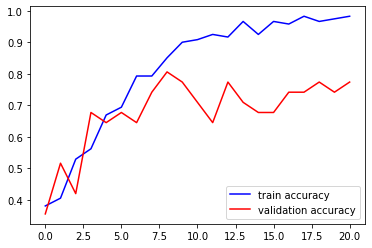

In [ ]:
plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_gensim.evaluate(X_test_pad, y_test) 

1/1 [==============================] - 0s 127ms/step - loss: 0.8466 - accuracy: 0.7742


[0.8466134071350098, 0.774193525314331]

In [ ]:
new_complaint = ['On 6.11.1995, Nasima Begum (PW.1), aged about 16 years filed a complaint alleging that on that day while she was going to attend her tuition alongwith her friend Nilufa Khatun, she met the appellant on the way who suddenly came and forcibly caught hold of her hair and planted a kiss, resultantly, she suffered a cut over her lower lip and started bleeding.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=171,padding='post')
pred = model_gensim.predict(padded)
labels = ['murder','kidnapping','sexual offense']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 48ms/step
[[0.00239872 0.00337697 0.99422437]] sexual offense


In [ ]:
from sklearn.metrics import classification_report

y_pred=model_gensim.predict(X_test_pad)
predicted = np.argmax(y_pred, axis=1)
report = classification_report(y_test, predicted)
print(report)

1/1 [==============================] - 0s 40ms/step
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.89      0.73      0.80        11
           2       0.75      0.90      0.82        10

    accuracy                           0.77        31
   macro avg       0.78      0.78      0.77        31
weighted avg       0.78      0.77      0.77        31

